~~to be updated ... please come back later ~~  
please see ver.2 in new notebook  

- this single stage model has ~~smiliar or~~ better performance then my two-stage model
- updated net architecture to exclude the use of grade mask loss which improve validation results
(please refer to old versions of notebook for initial net architecture)

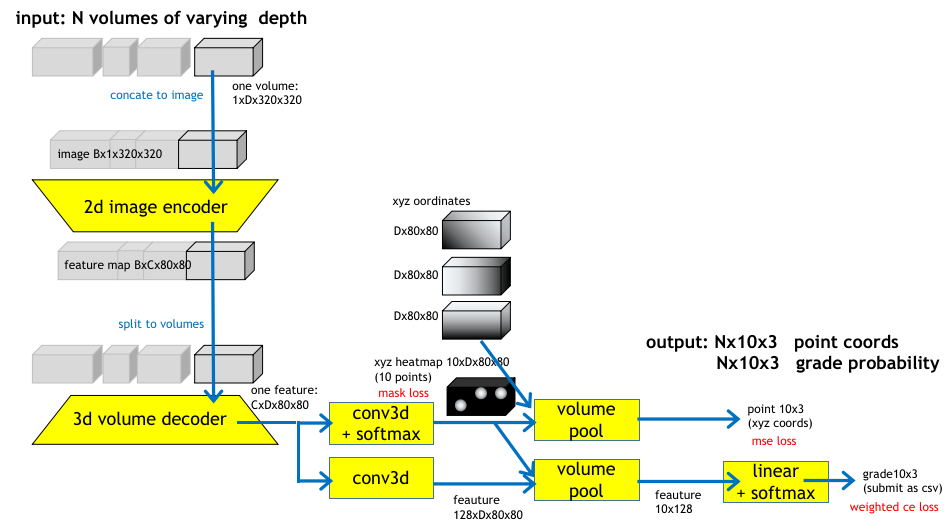

In [1]:
try: 
    import natsort  
except:
    %pip install natsort

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import timm
print('timm:',timm.__version__)

import cv2
import numpy as np
import pydicom
import glob
from natsort import natsorted
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

class dotdict(dict):
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

    def __getattr__(self, name):
        try:
            return self[name]
        except KeyError:
            raise AttributeError(name)

print('import ok!')

timm: 1.0.9
import ok!


# 1.  2d encoder + 3d unet-decoder

In [2]:
#modeling: 2d encoder + 3d unet-decoder, upscale 2x in xy only, i.e:
#  x = F.interpolate(x, scale_factor=(1,2,2), mode='nearest')

class MyDecoderBlock3d(nn.Module):
    def __init__(
            self,
            in_channel,
            skip_channel,
            out_channel,
    ):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv3d(in_channel + skip_channel, out_channel, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(out_channel),
            nn.ReLU(inplace=True),
        )
        self.attention1 = nn.Identity()
        self.conv2 = nn.Sequential(
            nn.Conv3d(out_channel, out_channel, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(out_channel),
            nn.ReLU(inplace=True),
        )
        self.attention2 = nn.Identity()

    def forward(self, x, skip=None):
        x = F.interpolate(x, scale_factor=(1,2,2), mode='nearest')
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
            x = self.attention1(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.attention2(x)
        return x
    
class MyUnetDecoder3d(nn.Module):
    def __init__(
            self,
            in_channel,
            skip_channel,
            out_channel,
    ):
        super().__init__()
        self.center = nn.Identity()

        i_channel = [in_channel, ] + out_channel[:-1]
        s_channel = skip_channel
        o_channel = out_channel
        block = [
            MyDecoderBlock3d(i, s, o)
            for i, s, o in zip(i_channel, s_channel, o_channel)
        ]
        self.block = nn.ModuleList(block)

    def forward(self, feature, skip):
        d = self.center(feature)
        decode = []
        for i, block in enumerate(self.block):  
            s = skip[i]
            d = block(d, s)
            decode.append(d)
        last = d
        return last, decode

    
# encoder helper
def pvtv2_encode(x, e):
    encode = []
    x = e.patch_embed(x)
    for stage in e.stages:
        x = stage(x); encode.append(x)
    return encode

# 2.  prediction head

In [3]:
#modeling: prediction head

# magic.1.: convert local pixelwise prediction to global volume prediction

def heatmap_to_coord(heatmap):
    num_image = len(heatmap)
    device = heatmap[0].device
    _,_, H, W = heatmap[0].shape
    D = max([h.shape[1] for h in heatmap])

    # create coordinates grid.
    x = torch.linspace(0, W - 1, W, device=device)
    y = torch.linspace(0, H - 1, H, device=device)
    z = torch.linspace(0, D - 1, D, device=device)

    point_xy=[]
    point_z =[]
    for i in range(num_image):
        num_point, D, H, W = heatmap[i].shape
        pos_x = x.reshape(1,1,1,W)
        pos_y = y.reshape(1,1,H,1)
        pos_z = z[:D].reshape(1,D,1,1)

        py = torch.sum(pos_y * heatmap[i], dim=(1,2,3))
        px = torch.sum(pos_x * heatmap[i], dim=(1,2,3))
        pz = torch.sum(pos_z * heatmap[i], dim=(1,2,3))

        point_xy.append(torch.stack([px,py]).T)
        point_z.append(pz)

    xy = torch.stack(point_xy)
    z = torch.stack(point_z)
    return xy, z


def heatmap_to_grade(heatmap, grade_mask):
    num_image = len(heatmap)
    grade = []
    for i in range(num_image):
        num_point, D, H, W = heatmap[i].shape
        C, D, H, W = grade_mask[i].shape
        g = grade_mask[i].reshape(1,C,D,H,W)#.detach()
        h = heatmap[i].reshape(num_point,1,D,H,W)#.detach()
        g = (h*g).sum(dim=(2,3,4))
        grade.append(g)
    grade = torch.stack(grade)
    return grade

# 3.  loss function
- per pixel loss
- per volume loss

In [4]:
#modeling: loss functions

# magic.2.: example shown here is for sagittal t1 neural foraminal narrowing points
# dynamic matching - becuase of ambiguous/confusion of ground truth labeling of L5 and S1,
# your predicted xy coordinates may be misaligned with ground truth xy. Hence you must 
# modified the grade target values as well in loss backpropagation

def do_dynamic_match_truth(xy, truth_xy, threshold=3):

    num_image, num_point, _2_ = xy.shape
    t = truth_xy[:, :5, 1].reshape(num_image, 5, 1)
    p = xy[:, :5, 1].reshape(num_image, 1, 5)
    diff = torch.abs(p - t)
    left, left_i = diff.min(-1)
    left_t = (left < threshold)
    
    t = truth_xy[:, 5:, 1].reshape(num_image, 5, 1)
    p = xy[:, 5:, 1].reshape(num_image, 1, 5)
    diff = torch.abs(p - t)
    right, right_i = diff.min(-1)
    right_t = (right < threshold)

    index = torch.cat([left_i,right_i+5],1).detach()
    valid = torch.cat([left_t,right_t],1).detach()
    return index, valid



def F_grade_loss(grade, truth):
    eps = 1e-5
    weight = torch.FloatTensor([1,2,4]).to(grade.device)

    t = truth.reshape(-1)
    g = grade.reshape(-1,3)

    #loss = F.nll_loss( torch.clamp(g, eps, 1-eps).log(), t,weight=weight, ignore_index=-1)
    loss = F.cross_entropy(g, t,weight=weight, ignore_index=-1)
    return loss

 
def F_zxy_loss(z, xy,  z_truth, xy_truth):
    m = z_truth!=-1
    z_truth = z_truth.float()
    loss = (
        F.mse_loss(z[m], z_truth[m]) + F.mse_loss(xy[m], xy_truth[m])
    )
    return loss


#https://discuss.pytorch.org/t/jensen-shannon-divergence/2626/11
#Jensen-Shannon divergence
def F_xyz_mask_loss(heatmap, truth, D):
    heatmap =  torch.split_with_sizes(heatmap, D, 0)
    truth =  torch.split_with_sizes(truth, D, 0)
    num_image = len(heatmap)

    loss =0
    for i in range(num_image):
        p,q = truth[i], heatmap[i]
        D,num_point,H,W = p.shape

        eps = 1e-8
        p = torch.clamp(p.transpose(1,0).flatten(1),eps,1-eps)
        q = torch.clamp(q.transpose(1,0).flatten(1),eps,1-eps)
        m = (0.5 * (p + q)).log()

        kl = lambda x,t: F.kl_div(x,t, reduction='batchmean', log_target=True)
        loss += 0.5 * (kl(m, p.log()) + kl(m, q.log()))
    loss = loss/num_image
    return loss


# 4. final model

In [5]:
class Net(nn.Module):
    def __init__(self, pretrained=False, cfg=None):
        super(Net, self).__init__()
        self.output_type = ['infer', 'loss']
        self.register_buffer('D', torch.tensor(0))
        self.register_buffer('mean', torch.tensor(0.5))
        self.register_buffer('std', torch.tensor(0.5))

        arch = 'pvt_v2_b4'

        encoder_dim = {
            'pvt_v2_b2': [64, 128, 320, 512],
            'pvt_v2_b4': [64, 128, 320, 512],
        }.get(arch, [768])

        decoder_dim = \
              [384, 192, 96]
              #[256, 128, 64]

        self.encoder = timm.create_model(
            model_name=arch, pretrained=pretrained, in_chans=3, num_classes=0, global_pool=''
        )
        self.decoder = MyUnetDecoder3d(
            in_channel=encoder_dim[-1],
            skip_channel=encoder_dim[:-1][::-1],
            out_channel=decoder_dim,
        )


        self.zxy_mask = nn.Conv3d(decoder_dim[-1], 10, kernel_size=1)
        self.grade_mask = nn.Conv3d(decoder_dim[-1], 128, kernel_size=1)
        self.grade = nn.Sequential(
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 3),
        )


    def forward(self, batch):
        device = self.D.device
        image = batch['image'].to(device)
        D = batch['D']
        num_image = len(D)

        B, H, W = image.shape
        image = image.reshape(B, 1, H, W)

        x = image.float() / 255
        x = (x - self.mean) / self.std
        x = x.expand(-1, 3, -1, -1)

        #---
        encode = pvtv2_encode(x, self.encoder)
        ##[print(f'encode_{i}', e.shape) for i,e in enumerate(encode)]
        encode = [ torch.split_with_sizes(e, D, 0) for e in encode ]

        grade_mask = []  #feature map
        zxy_mask   = []  #prob heatmap
        for i in range(num_image):
            e = [ encode[s][i].transpose(1,0).unsqueeze(0) for s in range(4) ]
            l, _ = self.decoder(
                feature=e[-1], skip=e[:-1][::-1]
            )

            g = self.grade_mask(l).squeeze(0)
            grade_mask.append(g)

            zxy = self.zxy_mask(l).squeeze(0)
            _,d,h,w = zxy.shape
            zxy = zxy.flatten(1).softmax(-1).reshape(-1,d,h,w)
            zxy_mask.append(zxy)

        ##print(D)
        ##[print(f'zxy_logit_{i}', x.shape) for i, x in enumerate(zxy_mask_prob)]

        xy, z = heatmap_to_coord(zxy_mask)
        ##print('xy', xy.shape, 'z', z.shape)

        #---
        num_point = xy.shape[1]
        grade = heatmap_to_grade(zxy_mask, grade_mask)
        #print('grade', grade.shape)
        grade = grade.reshape(num_image*num_point,-1)
        grade = self.grade(grade)
        grade = grade.reshape(num_image,num_point,3)
        ##print('grade', grade.shape)

        #---
        zxy_mask = torch.cat(zxy_mask, 1).transpose(1, 0)

        output = {}
        if 'loss' in self.output_type:
            output['zxy_mask_loss'] = F_xyz_mask_loss(zxy_mask, batch['zxy_mask'].to(device), D)
            output['zxy_loss'] = F_zxy_loss(z, xy, batch['z'].to(device), batch['xy'].to(device))

            #output['grade_loss'] = F_grade_loss(grade,  batch['grade'].to(device))
            if 1:
                index, valid = do_dynamic_match_truth(xy, batch['xy'].to(device))
                truth = batch['grade'].to(device)
                truth_matched = []
                for i in range(num_image):
                    truth_matched.append(truth[i][index[i]])
                truth_matched = torch.stack(truth_matched)
                output['grade_loss'] = F_grade_loss(grade[valid],  truth_matched[valid])

        if 'infer' in self.output_type:
            output['zxy_mask'] = zxy_mask
            output['xy'] = xy
            output['z'] = z
            output['grade'] = F.softmax(grade,-1)


        return output

In [6]:
#demo with dummy data

def run_check_net():
   
    D = [6, 7, 9, 11, 3, 4, 5] #input volumes with variable depth
    num_image  = len(D)
    
    image_size = 320
    mask_size  = image_size//4
    B = sum(D)
    num_point = 10


    batch = {
        'D': D,
        'image': torch.from_numpy( np.random.uniform(-1, 1, ( B, image_size, image_size))).byte(),
        'zxy_mask': torch.from_numpy(np.random.uniform(0,1,(B, num_point, mask_size, mask_size))).float(),
        'z': torch.from_numpy(np.random.choice(min(D), (num_image, num_point))).long(),
        'xy': torch.from_numpy(np.random.choice(image_size, (num_image, num_point, 2))).float(),
        'grade': torch.from_numpy(np.random.choice(3, (num_image, num_point))).long(), 
    }

    net = Net(pretrained=False, cfg=None)#.cuda()


    with torch.no_grad():
        with torch.cuda.amp.autocast(enabled=True):
            output = net(batch)
    # ---
    print('batch')
    for k, v in batch.items():
        if k == 'D':
            print(f'{k:>32} : {v} ')
        else:
            print(f'{k:>32} : {v.shape} ')

    print('output')
    for k, v in output.items():
        if 'loss' not in k:
            print(f'{k:>32} : {v.shape} ')
    print('loss')
    for k, v in output.items():
        if 'loss' in k:
            print(f'{k:>32} : {v.item()} ')



run_check_net()

/tmp/ipykernel_24438/3920000962.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


batch
                               D : [6, 7, 9, 11, 3, 4, 5] 
                           image : torch.Size([45, 320, 320]) 
                        zxy_mask : torch.Size([45, 10, 80, 80]) 
                               z : torch.Size([7, 10]) 
                              xy : torch.Size([7, 10, 2]) 
                           grade : torch.Size([7, 10]) 
output
                        zxy_mask : torch.Size([45, 10, 80, 80]) 
                              xy : torch.Size([7, 10, 2]) 
                               z : torch.Size([7, 10]) 
                           grade : torch.Size([7, 10, 3]) 
loss
                   zxy_mask_loss : 7127.2470703125 
                        zxy_loss : 18700.873046875 
                      grade_loss : 1.1207894086837769 


In [12]:
#demo with real kaggle data and visualisation


DATA_KAGGLE_DIR = '/home/ai/neo/data/rsna-2024-lumbar-spine-degenerative-classification'

def np_dot(a,b):
    return np.sum(a * b, 1)

def normalise_to_8bit(x, lower=0.1, upper=99.9): 
    lower, upper = np.percentile(x, (lower, upper))
    x = np.clip(x, lower, upper)
    x = x - np.min(x)
    x = x / np.max(x)
    return (x * 255).astype(np.uint8)

def read_series(study_id,series_id,series_description):
    error_code = ''
    
    data_kaggle_dir = DATA_KAGGLE_DIR
    dicom_dir = f'{data_kaggle_dir}/train_images/{study_id}/{series_id}'

    # read dicom file
    dicom_file = natsorted(glob.glob(f'{dicom_dir}/*.dcm'))
    instance_number = [int(f.split('/')[-1].split('.')[0]) for f in dicom_file]
    dicom = [pydicom.dcmread(f) for f in dicom_file]

    # make dicom header df
    dicom_df = []
    for i, d in zip(instance_number, dicom):  # d__.dict__
        dicom_df.append(
            dotdict(
                study_id=study_id,
                series_id=series_id,
                series_description=series_description,
                instance_number=i,
                # InstanceNumber = d.InstanceNumber,
                ImagePositionPatient=[float(v) for v in d.ImagePositionPatient],
                ImageOrientationPatient=[float(v) for v in d.ImageOrientationPatient],
                PixelSpacing=[float(v) for v in d.PixelSpacing],
                SpacingBetweenSlices=float(d.SpacingBetweenSlices),
                SliceThickness=float(d.SliceThickness),
                grouping=str([round(float(v), 3) for v in d.ImageOrientationPatient]),
                H=d.pixel_array.shape[0],
                W=d.pixel_array.shape[1],
            )
        )
    dicom_df = pd.DataFrame(dicom_df)
    # dicom_df.to_csv('dicom_df.csv',index=False)
    # exit(0)

    #----
    if ((dicom_df.W.nunique()!=1) or (dicom_df.H.nunique()!=1)):
        error_code = '[multi-shape]'
    Wmax = dicom_df.W.max()
    Hmax = dicom_df.H.max()

    # sort slices
    dicom_df = [d for _, d in dicom_df.groupby('grouping')]

    data = []
    sort_data_by_group = []
    for df in dicom_df:
        position = np.array(df['ImagePositionPatient'].values.tolist())
        orientation = np.array(df['ImageOrientationPatient'].values.tolist())
        normal = np.cross(orientation[:, :3], orientation[:, 3:])
        projection = np_dot(normal, position)
        df.loc[:, 'projection'] = projection
        df = df.sort_values('projection')


        # todo: assert all slices are continous ??
        # use  (position[-1]-position[0])/N = SpacingBetweenSlices ??
        assert len(df.SliceThickness.unique()) == 1
        #assert len(df.SpacingBetweenSlices.unique()) == 1


        volume = []
        for i in df.instance_number:
            v = dicom[instance_number.index(i)].pixel_array
            if error_code.find('multi-shape')!=-1:
                H,W = v.shape
                v=np.pad(v,[(0,Hmax-H),(0,Wmax-W)],'reflect')
            volume.append(v)

        volume = np.stack(volume)
        volume = normalise_to_8bit(volume)

        data.append(dotdict(
            df=df,
            volume=volume,
        ))

        if 'sagittal' in series_description.lower():
            sort_data_by_group.append(position[0, 0])  # x
        if 'axial' in series_description.lower():
            sort_data_by_group.append(position[0, 2])  # z

    data = [r for _, r in sorted(zip(sort_data_by_group, data))]
    for i, r in enumerate(data):
        r.df.loc[:, 'group'] = i

    df = pd.concat([r.df for r in data])
    df.loc[:, 'z'] = np.arange(len(df))
    volume = np.concatenate([r.volume for r in data])
    return volume, df, error_code

def do_resize_and_center(
    image, reference_size
):
   
    H, W = image.shape[:2]
    if (W==reference_size) & (H==reference_size):
        return image, (1,0,0)

    s = reference_size / max(H, W)
    m = cv2.resize(image, dsize=None, fx=s, fy=s)
    h, w = m.shape[:2]
    padx0 = (reference_size-w)//2
    padx1 = reference_size-w-padx0
    pady0 = (reference_size-h)//2
    pady1 = reference_size-h-pady0

    m = np.pad(m, [[pady0, pady1], [padx0, padx1], [0, 0]], mode='constant', constant_values=0)
    #p = point * s +[[padx0,pady0]]
    scale_param = s,padx0,pady0
    return m, scale_param


#read kaggle data----------------------------------------------------------
study_id = 267842058
series_id = 894248358
series_description = 'sagittal_t1'

#ground truth
truth_grade=[
    'Normal/Mild',
    'Moderate',
    'Severe',
    'Moderate',
    'Severe',
    'Normal/Mild',
    'Normal/Mild',
    'Moderate',
    'Severe',
    'Severe',
]



volume, dicom_df, _ = read_series(study_id,series_id,series_description)
print('volume', volume.shape)

image = np.ascontiguousarray(volume.transpose(1,2,0))
image, scale_param = do_resize_and_center(
    image, reference_size=320
)
image = np.ascontiguousarray(image.transpose(2,0,1))
print('image', image.shape)

batch = {
    'D': [len(image)], #only one volume
    'image': torch.from_numpy(image).byte(), 
}

net = Net(pretrained=False, cfg=None)#
state_dict = torch.load(
    '/home/ai/neo/data/model/00034142.pth',
    map_location=lambda storage, loc: storage, weights_only=True)['state_dict']
print(net.load_state_dict(state_dict, strict=False))  # True

#net = net.cuda()
net = net.eval()
net.output_type = ['infer']

with torch.no_grad():
    with torch.cuda.amp.autocast(enabled=True):
        output = net(batch)

zxy_mask = output['zxy_mask'].data.cpu().numpy()
xy = output['xy'][0].data.cpu().numpy()
z  = output['z'][0].data.cpu().numpy()
grade = output['grade'][0].data.cpu().numpy()
# print(grade) 
print('predict ok!')

volume (15, 384, 384)
image (15, 320, 320)
<All keys matched successfully>


/tmp/ipykernel_24438/158862697.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


[[5.8505911e-01 3.8154793e-01 3.3392970e-02]
 [8.3592772e-02 8.3263505e-01 8.3772242e-02]
 [1.0551679e-02 2.0734586e-01 7.8210247e-01]
 [5.0823011e-02 7.8583646e-01 1.6334045e-01]
 [2.3717221e-03 6.2945738e-02 9.3468261e-01]
 [9.2570031e-01 6.8770915e-02 5.5287238e-03]
 [9.6307671e-01 3.6784787e-02 1.3840926e-04]
 [9.6058823e-02 7.8911424e-01 1.1482688e-01]
 [1.4822155e-03 4.2814888e-02 9.5570296e-01]
 [6.1358549e-03 8.0172658e-02 9.1369152e-01]]
predict ok!


prediction results ...
truth: Normal/Mild  | predict: 0.58506, 0.38155, 0.03339
truth: Moderate     | predict: 0.08359, 0.83264, 0.08377
truth: Severe       | predict: 0.01055, 0.20735, 0.78210
truth: Moderate     | predict: 0.05082, 0.78584, 0.16334
truth: Severe       | predict: 0.00237, 0.06295, 0.93468
truth: Normal/Mild  | predict: 0.92570, 0.06877, 0.00553
truth: Normal/Mild  | predict: 0.96308, 0.03678, 0.00014
truth: Moderate     | predict: 0.09606, 0.78911, 0.11483
truth: Severe       | predict: 0.00148, 0.04281, 0.95570
truth: Severe       | predict: 0.00614, 0.08017, 0.91369



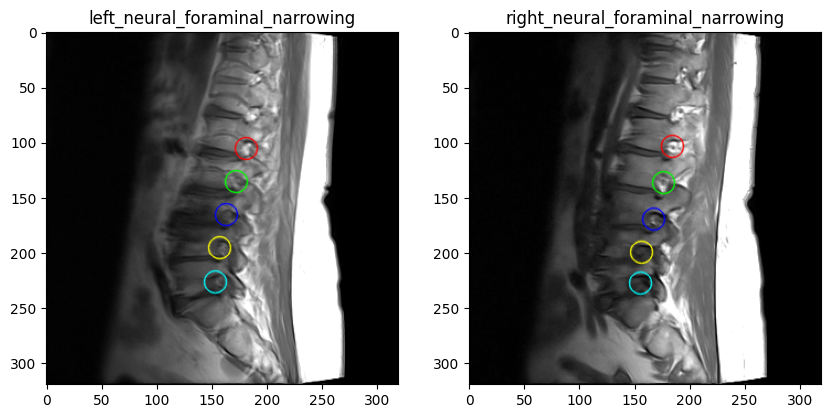

In [9]:
print('prediction results ...')
for i in range(10):
    print(f'truth: {truth_grade[i]:<12s} | predict: {grade[i,0]:0.5f}, {grade[i,1]:0.5f}, {grade[i,2]:0.5f}')
print('')


level_color = [
    [255, 0, 0],
    [0, 255, 0],
    [0, 0, 255],
    [255, 255, 0],
    [0, 255, 255],
]

s = np.round(z).astype(np.int32)

left_image = image[s[:5]].mean(0)
left_image = (np.clip(left_image/128,0,1))*255 #improve contrast for visualisation
left_image = left_image.astype(np.uint8)
left_image = np.dstack([left_image]*3)
for i in range(0,5):
    x,y = xy[i]*4
    x = int(round(x))
    y = int(round(y))
    cv2.circle(left_image,(x,y),10,level_color[i%5],1,cv2.LINE_AA)
    

right_image = image[s[5:]].mean(0).astype(np.uint8)
right_image = (np.clip(right_image/128,0,1))*255 #improve contrast for visualisation
right_image = right_image.astype(np.uint8)
right_image = np.dstack([right_image]*3)
for i in range(5,10):
    x,y = xy[i]*4
    x = int(round(x))
    y = int(round(y))
    cv2.circle(right_image,(x,y),10,level_color[i%5],1,cv2.LINE_AA)
    


fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].set_title('left_neural_foraminal_narrowing')
axs[0].imshow(left_image, cmap='gray')
axs[1].set_title('right_neural_foraminal_narrowing')
axs[1].imshow(right_image, cmap='gray')
plt.show()




In [11]:
%%script false --no-raise-error

#enable this to show 3d plot
#too slow to load!

import plotly.graph_objects as go 
import plotly.express as px 

for i in range(10):
    print(f'predict: {z[i]:5.1f}, {xy[i,0]:5.1f}, {xy[i,1]:5.1f}')
print('')



print('zxy_mask', zxy_mask.shape)
p = zxy_mask.sum(1)

D,H,W = p.shape
gx, gy, gz = np.meshgrid(
     np.linspace(0, W, W) , 
     np.linspace(0, D, D) , 
     np.linspace(0, H, H) 
)


fig = go.Figure(data=go.Volume( 
    x=gx.flatten(), 
    y=gy.flatten(), 
    z=gz.flatten(), 
    value=p.flatten(), 
    opacity=0.5,  
    isomax=p.max(),  
    isomin=0.1,
    surface_count=100,
    caps= dict(x_show=False, y_show=False, z_show=True), 
)) 
fig.update_layout(
    scene = dict(
        aspectmode='data' 
        # aspectmode='cube'
    ),
)
fig.show()
